## Import modules and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scipy import stats

# Set style of plots
mpl.rcParams['figure.dpi'] = 180
random_state = 42
sns.reset_defaults()
sns.set_palette(['#4c72b0', '#c44e52', '#dd8452', '#55a868', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd'])
print(sns.color_palette().as_hex())
sns.color_palette()

sns.set_style("whitegrid", {'text.color': 'black', 'xtick.color': 'black', 'ytick.color': 'black',
                            'axes.labelcolor': 'black', 'xtick.bottom': True, 'ytick.left': True})
#sns.axes_style()

['#4c72b0', '#c44e52', '#dd8452', '#55a868', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


## Read in data

In [2]:
# Read data
df = pd.read_csv('earthquake_data_tsunami.csv')
df_original = df.copy()

# Only train data after year 2013
# df = df[df['Year'] >= 2013]

# tsunami_01: target 0/1 values, tsunami: str values
df['tsunami_01'] = df['tsunami']
df['tsunami'] = df['tsunami_01'].map({0: 'no tsunami', 1: 'tsunami'})

# Read in nasa_dist_to_coast data and add to dataframe
#dist_to_coast = pd.read_csv('nasa_dist_to_coast.txt')
#df['dist_to_coast'] = dist_to_coast

# Check missing/null values
print(f"Data shape:\n {df.shape}\n")
print(df.info())

df.head()


Data shape:
 (782, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   magnitude   782 non-null    float64
 1   cdi         782 non-null    int64  
 2   mmi         782 non-null    int64  
 3   sig         782 non-null    int64  
 4   nst         782 non-null    int64  
 5   dmin        782 non-null    float64
 6   gap         782 non-null    float64
 7   depth       782 non-null    float64
 8   latitude    782 non-null    float64
 9   longitude   782 non-null    float64
 10  Year        782 non-null    int64  
 11  Month       782 non-null    int64  
 12  tsunami     782 non-null    object 
 13  tsunami_01  782 non-null    int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 85.7+ KB
None


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,tsunami_01
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,tsunami,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,no tsunami,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,tsunami,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,tsunami,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,tsunami,1


## Exploratory Data Analysis (EDA)

### Features description

- Magnitude and intensity-related features:
    - **magnitude**: 6.5-9.1, Earthquake magnitude(Richter scale)
    - **mmi**: 1-9, Modified Mercalli Intensity (instrumental) 麥卡利震度分級
    - **cdi**: 0-9, Community Decimal Intensity (felt intensity) human experience of shaking
    - **sig**: 	650 - 2910, Event significance score, a calculated score by the USGS that combines magnitude, felt reports, and estimated impact

- Geometry and distance-related features
    - **depth**: Earthquake focal depth (km) Shallow earthquakes (less than 70km) are more likely to cause tsunami because they can displace the seafloor more directly.
    - **latitude**: Epicenter latitude (WGS84)
    - **longitude**: Epicenter longitude (WGS84)
    - an epicenter location close to the coastline or under the ocean is more likely to trigger tsunami
- Data Quality & Reliability features:
    - **nst**: Number of seismic monitoring stations, accuracy of data
    - **dmin**: 0.0 - 17.7, Distance to nearest seismic station (degrees),  smaller values means calculated depth is more accurate
    - **gap**: 0.0 - 239.0, Azimuthal gap between stations (degrees), Location reliability, coverage of stations around epicenter

- Temporal features: **year**, **month**,
used to find "seasonality" in data

In [3]:
df.describe()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami_01
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,870.108696,230.250639,1.325757,25.038990,75.883199,3.538100,52.609199,2012.280051,6.563939,0.388747
std,0.445514,3.169939,1.462724,322.465367,250.188177,2.218805,24.225067,137.277078,27.303429,117.898886,6.099439,3.507866,0.487778
min,6.500000,0.000000,1.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000,2001.000000,1.000000,0.000000
25%,6.600000,0.000000,5.000000,691.000000,0.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050,2007.000000,3.250000,0.000000
50%,6.800000,5.000000,6.000000,754.000000,140.000000,0.000000,20.000000,26.295000,-2.572500,109.426000,2013.000000,7.000000,0.000000
75%,7.100000,7.000000,7.000000,909.750000,445.000000,1.863000,30.000000,49.750000,24.654500,148.941000,2017.000000,10.000000,1.000000
max,9.100000,9.000000,9.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000,2022.000000,12.000000,1.000000


### Tsunami count by year

The dataset only contained tsunami records for all years.

      tsunami  count  percentage
0  no tsunami    478    61.12532
1     tsunami    304    38.87468


/tmp/ipython-input-1868610694.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


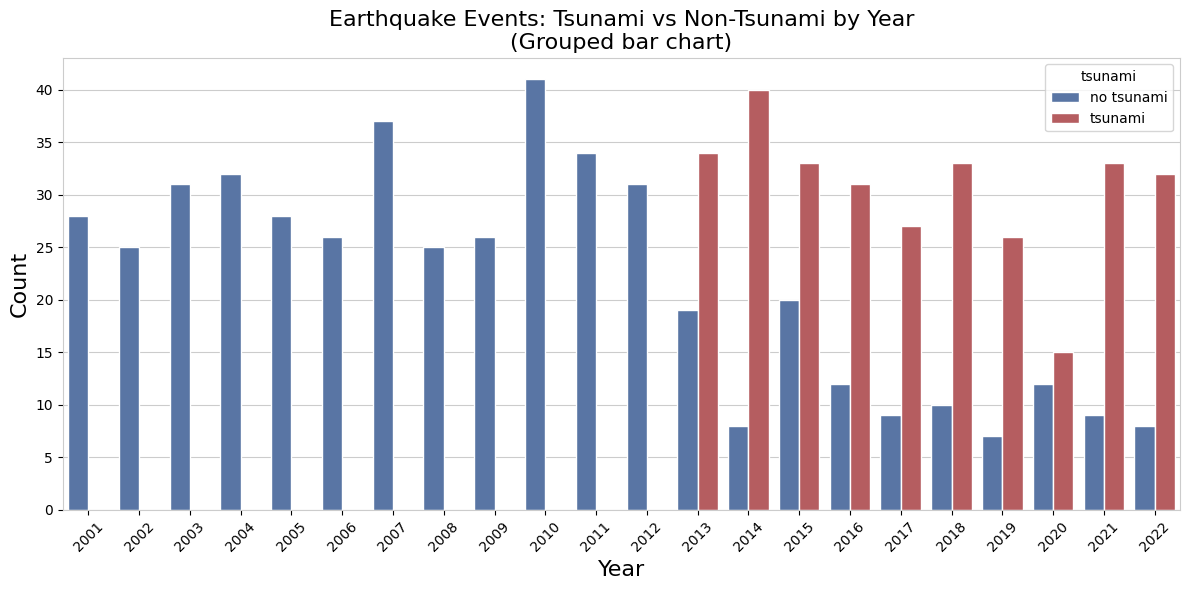

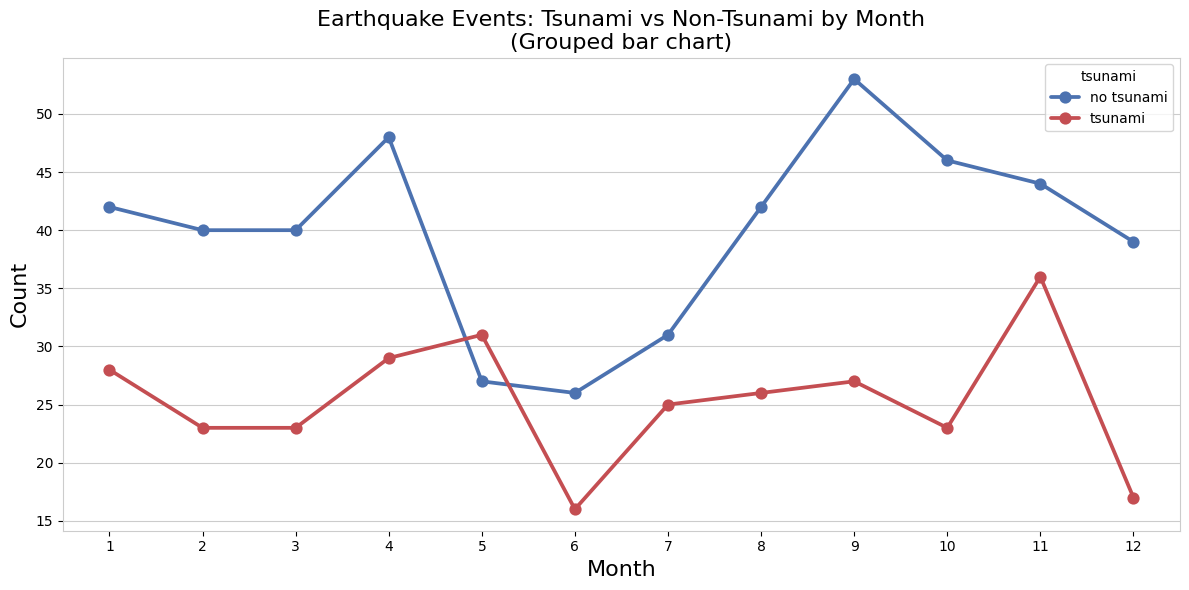

In [4]:
# Tsunami vs. Non-tsunami count
tsunami_counts = df['tsunami'].value_counts().rename('count').reset_index()
tsunami_counts['percentage'] = tsunami_counts['count'] / tsunami_counts['count'].sum() * 100
print(tsunami_counts)

# Plot tsunami counts by year
tsunami_counts_by_year = df.groupby('Year')['tsunami'].value_counts().rename('count').reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=tsunami_counts_by_year, x='Year', y='count', hue='tsunami', ax=ax)
ax.set_xlabel('Year', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Earthquake Events: Tsunami vs Non-Tsunami by Year\n(Grouped bar chart)', fontsize=16)
plt.tight_layout()
plt.show()

# Plot tsunami counts by month - seasonal patterns
tsunami_counts_by_month = df.groupby('Month')['tsunami'].value_counts().rename('count').reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.pointplot(data=tsunami_counts_by_month, x='Month', y='count', hue='tsunami', ax=ax)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Earthquake Events: Tsunami vs Non-Tsunami by Month\n(Grouped bar chart)', fontsize=16)
plt.tight_layout()
plt.show()

### Features correlation
- magnitude, cdi, mmi, sig have relatively strong positive correlation

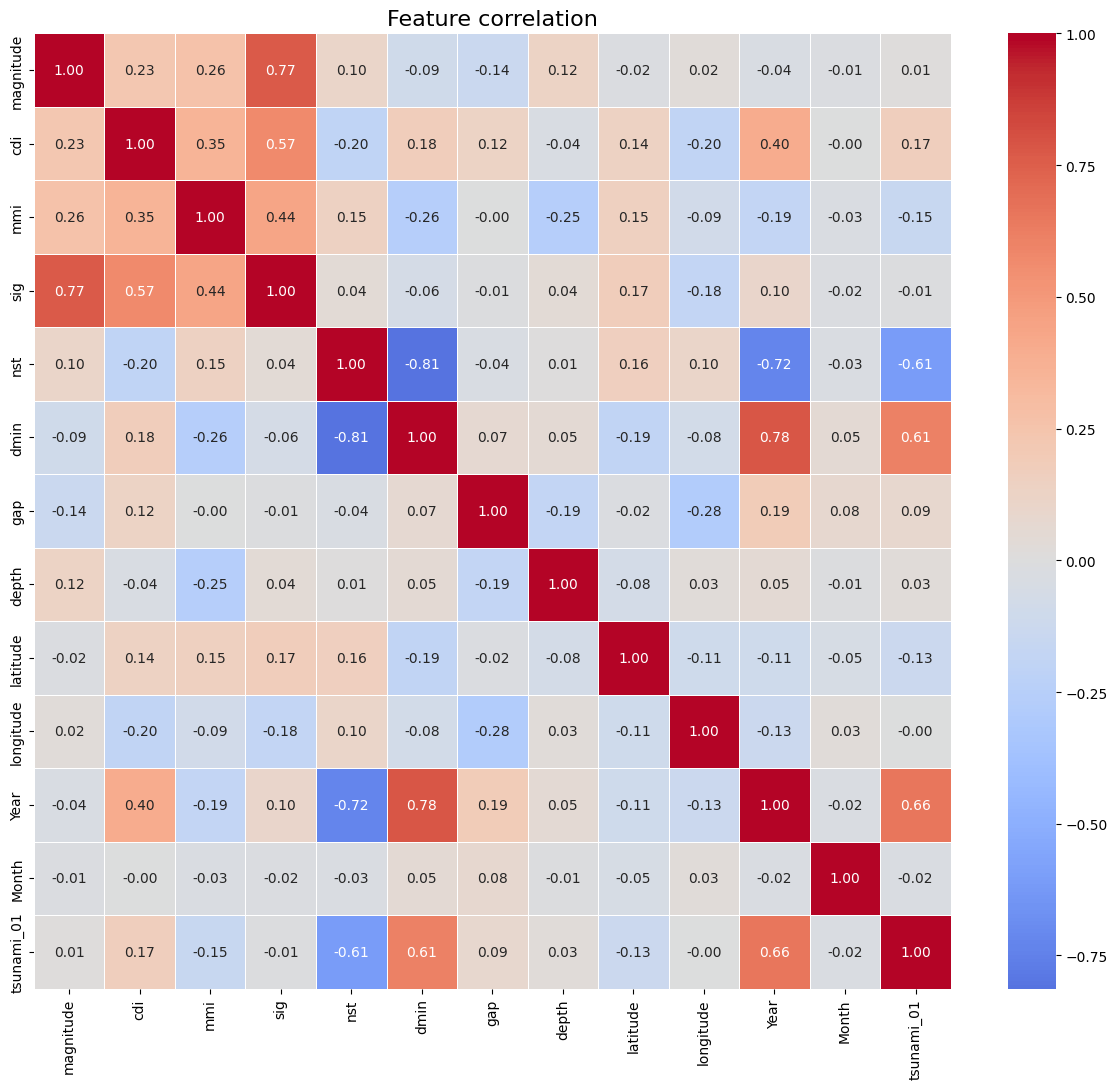

In [5]:
# Feature correlation of original features
fig, ax = plt.subplots(figsize=(12, 11))
sns.heatmap(df[df.columns.drop(['tsunami'])].corr(method='spearman'), ax=ax,
            annot=True, fmt='.2f', linewidth=0.5,
            cmap='coolwarm', center=0)
ax.set_title('Feature correlation', fontsize=16)
plt.tight_layout()
plt.show()

 ### T-test for the means of two independent samples of tsunami and no-tsunami

 Features that pass the T-test: magnitude, depth, latitude

In [6]:
# T-test of tsunami & no-tsunami
with_tsunami = df[df['tsunami'] == 'tsunami'][df.columns.drop(['tsunami', 'Year', 'Month'])]
no_tsunami = df[df['tsunami'] == 'no tsunami'][df.columns.drop(['tsunami', 'Year', 'Month'])]

t_stat, p_value = stats.ttest_ind(with_tsunami, no_tsunami)
print("Features t-test results")
for i, feature in enumerate(df.columns.drop(['tsunami', 'Year', 'Month'])):
    print(f"[{feature}] t stat: {t_stat[i]:.6f}, p value: {p_value[i]:.6f}")
    if p_value[i] < 0.05:
        print("Significant difference in mean")
    else:
        print("No significant difference")
    print()

Features t-test results
[magnitude] t stat: -0.131991, p value: 0.895025
No significant difference

[cdi] t stat: 4.534590, p value: 0.000007
Significant difference in mean

[mmi] t stat: -4.161046, p value: 0.000035
Significant difference in mean

[sig] t stat: -0.432933, p value: 0.665183
No significant difference

[nst] t stat: -20.958976, p value: 0.000000
Significant difference in mean

[dmin] t stat: 12.216270, p value: 0.000000
Significant difference in mean

[gap] t stat: 3.271991, p value: 0.001115
Significant difference in mean

[depth] t stat: 1.589302, p value: 0.112397
No significant difference

[latitude] t stat: -3.182222, p value: 0.001519
Significant difference in mean

[longitude] t stat: -3.856235, p value: 0.000125
Significant difference in mean

[tsunami_01] t stat: inf, p value: 0.000000
Significant difference in mean



/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


### Magnitude and intensity-related features

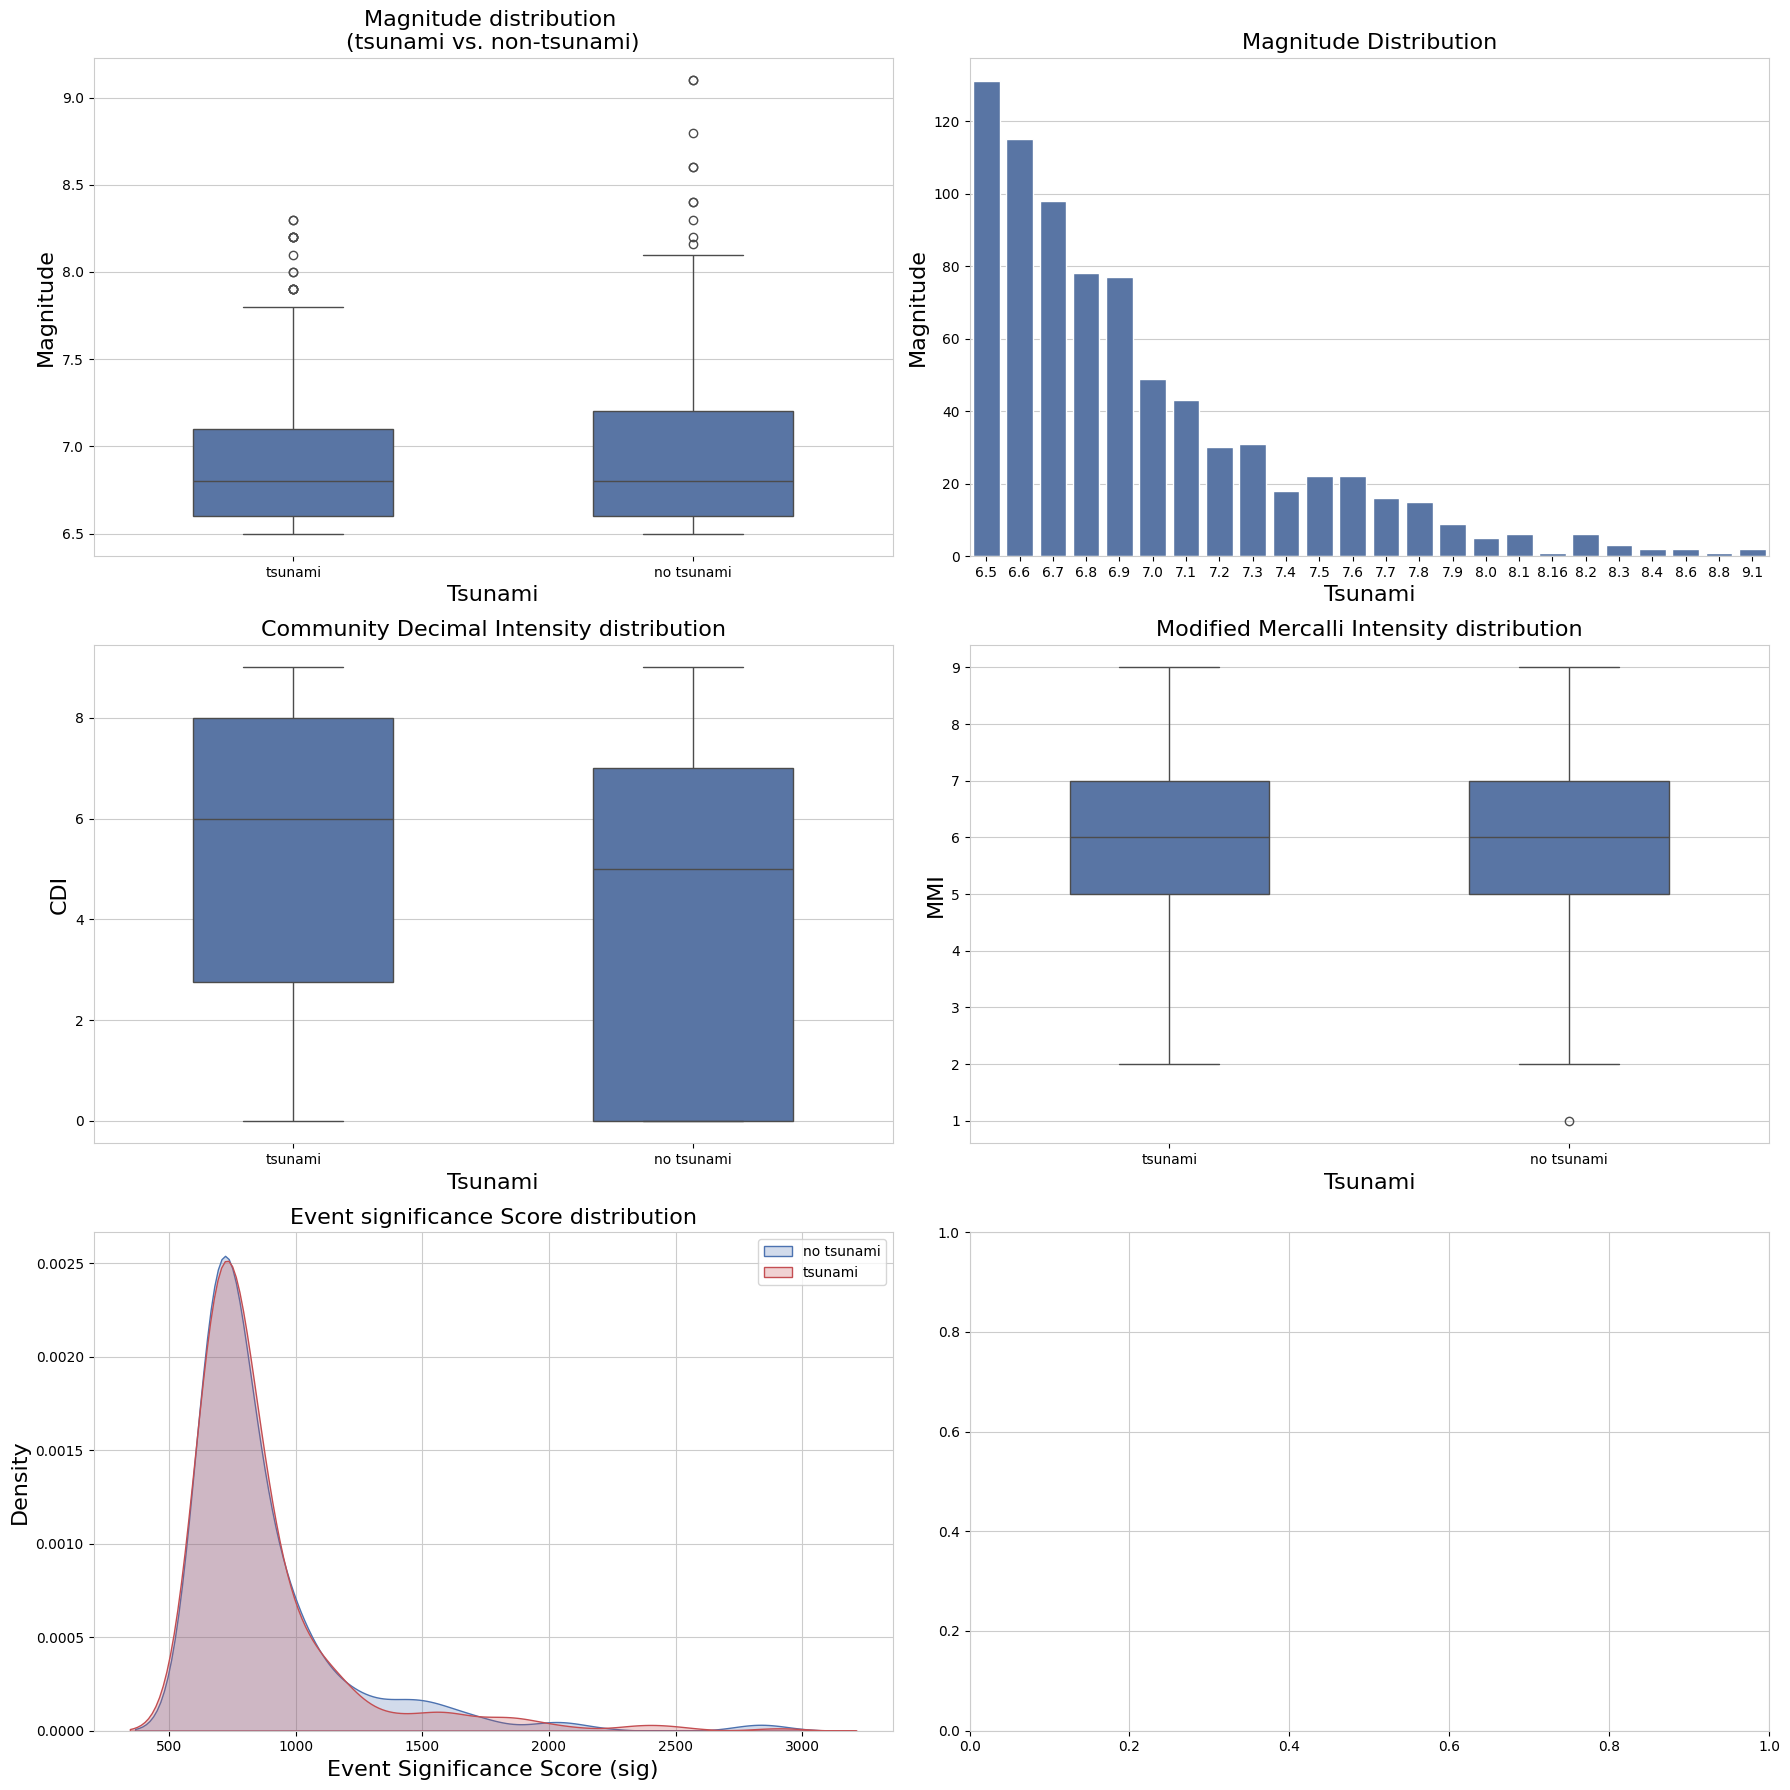

In [7]:
# Magnitude, cdi, mmi, sig
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
ax = axs[0, 0]
sns.boxplot(data=df, ax=ax, x="tsunami", y="magnitude", width=0.5)
ax.set_xlabel('Tsunami', fontsize=16)
ax.set_ylabel('Magnitude', fontsize=16)
ax.set_title('Magnitude distribution \n(tsunami vs. non-tsunami)', fontsize=16)

ax = axs[0, 1]
sns.countplot(data=df, ax=ax, x="magnitude")
ax.set_xlabel('Tsunami', fontsize=16)
ax.set_ylabel('Magnitude', fontsize=16)
ax.set_title('Magnitude Distribution', fontsize=16)

ax = axs[1, 0]
sns.boxplot(data=df, ax=ax, x="tsunami", y="cdi", width=0.5)
ax.set_xlabel('Tsunami', fontsize=16)
ax.set_ylabel('CDI', fontsize=16)
ax.set_title('Community Decimal Intensity distribution', fontsize=16)

ax = axs[1, 1]
sns.boxplot(data=df, ax=ax, x="tsunami", y="mmi", width=0.5)
ax.set_xlabel('Tsunami', fontsize=16)
ax.set_ylabel('MMI', fontsize=16)
ax.set_title('Modified Mercalli Intensity distribution', fontsize=16)

ax = axs[2, 0]
sns.kdeplot(data=df[df['tsunami'] == "no tsunami"], ax=ax, x="sig", fill=True)
sns.kdeplot(data=df[df['tsunami'] == "tsunami"], ax=ax, x="sig", fill=True)
ax.set_xlabel('Event Significance Score (sig)', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.legend(['no tsunami', 'tsunami'])
ax.set_title('Event significance Score distribution', fontsize=16)

plt.tight_layout()
plt.show()

### Geometry and distance-related features
- most of the data are shallow earthquakes
- earthquakes in the same depth category with higher magnitude are more likely to result in tsunami
- tsunami occur near coastal areas, earthquakes that happen in continental regions does not trigger tsunami

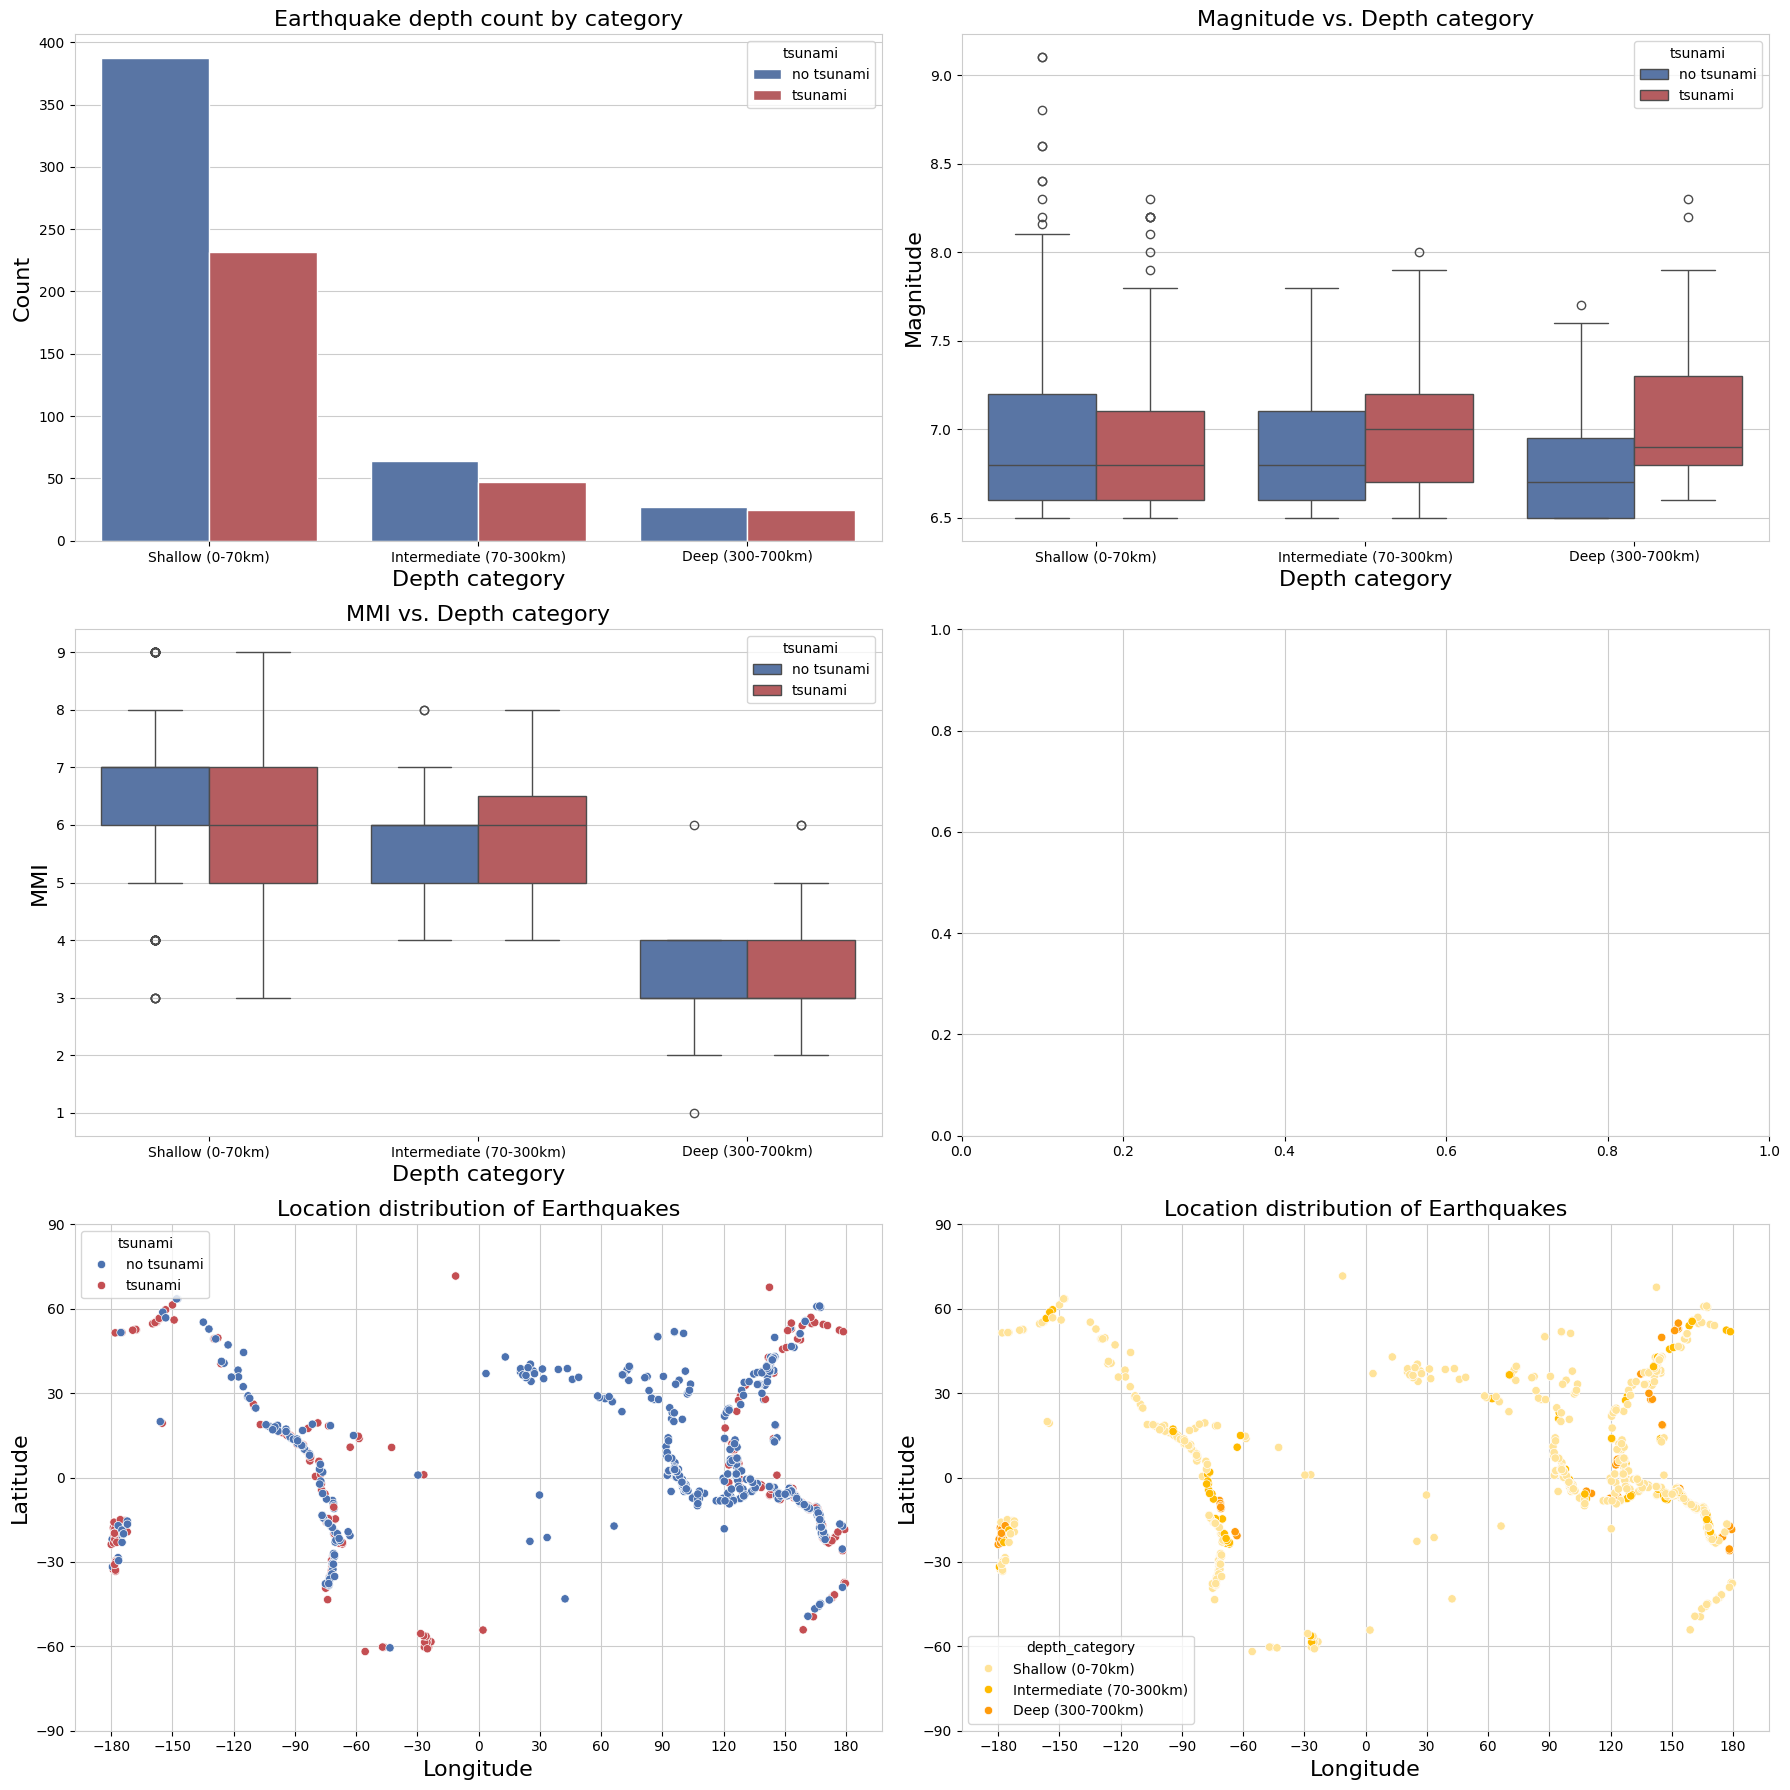

In [8]:
# Depth, latitude, longitude
df['depth_category'] = pd.cut(df['depth'], bins=[0, 70, 300, 700],
                              labels=['Shallow (0-70km)', 'Intermediate (70-300km)', 'Deep (300-700km)'])
fig, axs = plt.subplots(3, 2, figsize=(18, 18))
ax = axs[0, 0]
sns.countplot(data=df, ax=ax, x="depth_category", hue="tsunami", hue_order=['no tsunami', 'tsunami'])
ax.set_xlabel('Depth category', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Earthquake depth count by category', fontsize=16)

ax = axs[0, 1]
sns.boxplot(data=df, ax=ax, x="depth_category", y="magnitude", hue="tsunami", hue_order=['no tsunami', 'tsunami'])
ax.set_xlabel('Depth category', fontsize=16)
ax.set_ylabel('Magnitude', fontsize=16)
ax.set_title('Magnitude vs. Depth category', fontsize=16)

ax = axs[1, 0]
sns.boxplot(data=df, ax=ax, x="depth_category", y="mmi", hue="tsunami", hue_order=['no tsunami', 'tsunami'])
ax.set_xlabel('Depth category', fontsize=16)
ax.set_ylabel('MMI', fontsize=16)
ax.set_title('MMI vs. Depth category', fontsize=16)

ax = axs[2, 0]
sns.scatterplot(data=df, ax=ax, x="longitude", y="latitude", hue="tsunami", hue_order=['no tsunami', 'tsunami'])
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xticks(np.arange(-180, 181, 30))
ax.set_yticks(np.arange(-90, 91, 30))
ax.set_title('Location distribution of Earthquakes', fontsize=16)

ax = axs[2, 1]
sns.scatterplot(data=df, ax=ax, x="longitude", y="latitude", hue="depth_category", palette=['#ffe399', '#ffbb00', '#ff9b0b'])
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xticks(np.arange(-180, 181, 30))
ax.set_yticks(np.arange(-90, 91, 30))
ax.set_title('Location distribution of Earthquakes', fontsize=16)

plt.tight_layout()
plt.show()

### Data Quality & Reliability features
- NST and gap is highly skewed

/tmp/ipython-input-1472124030.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-1472124030.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


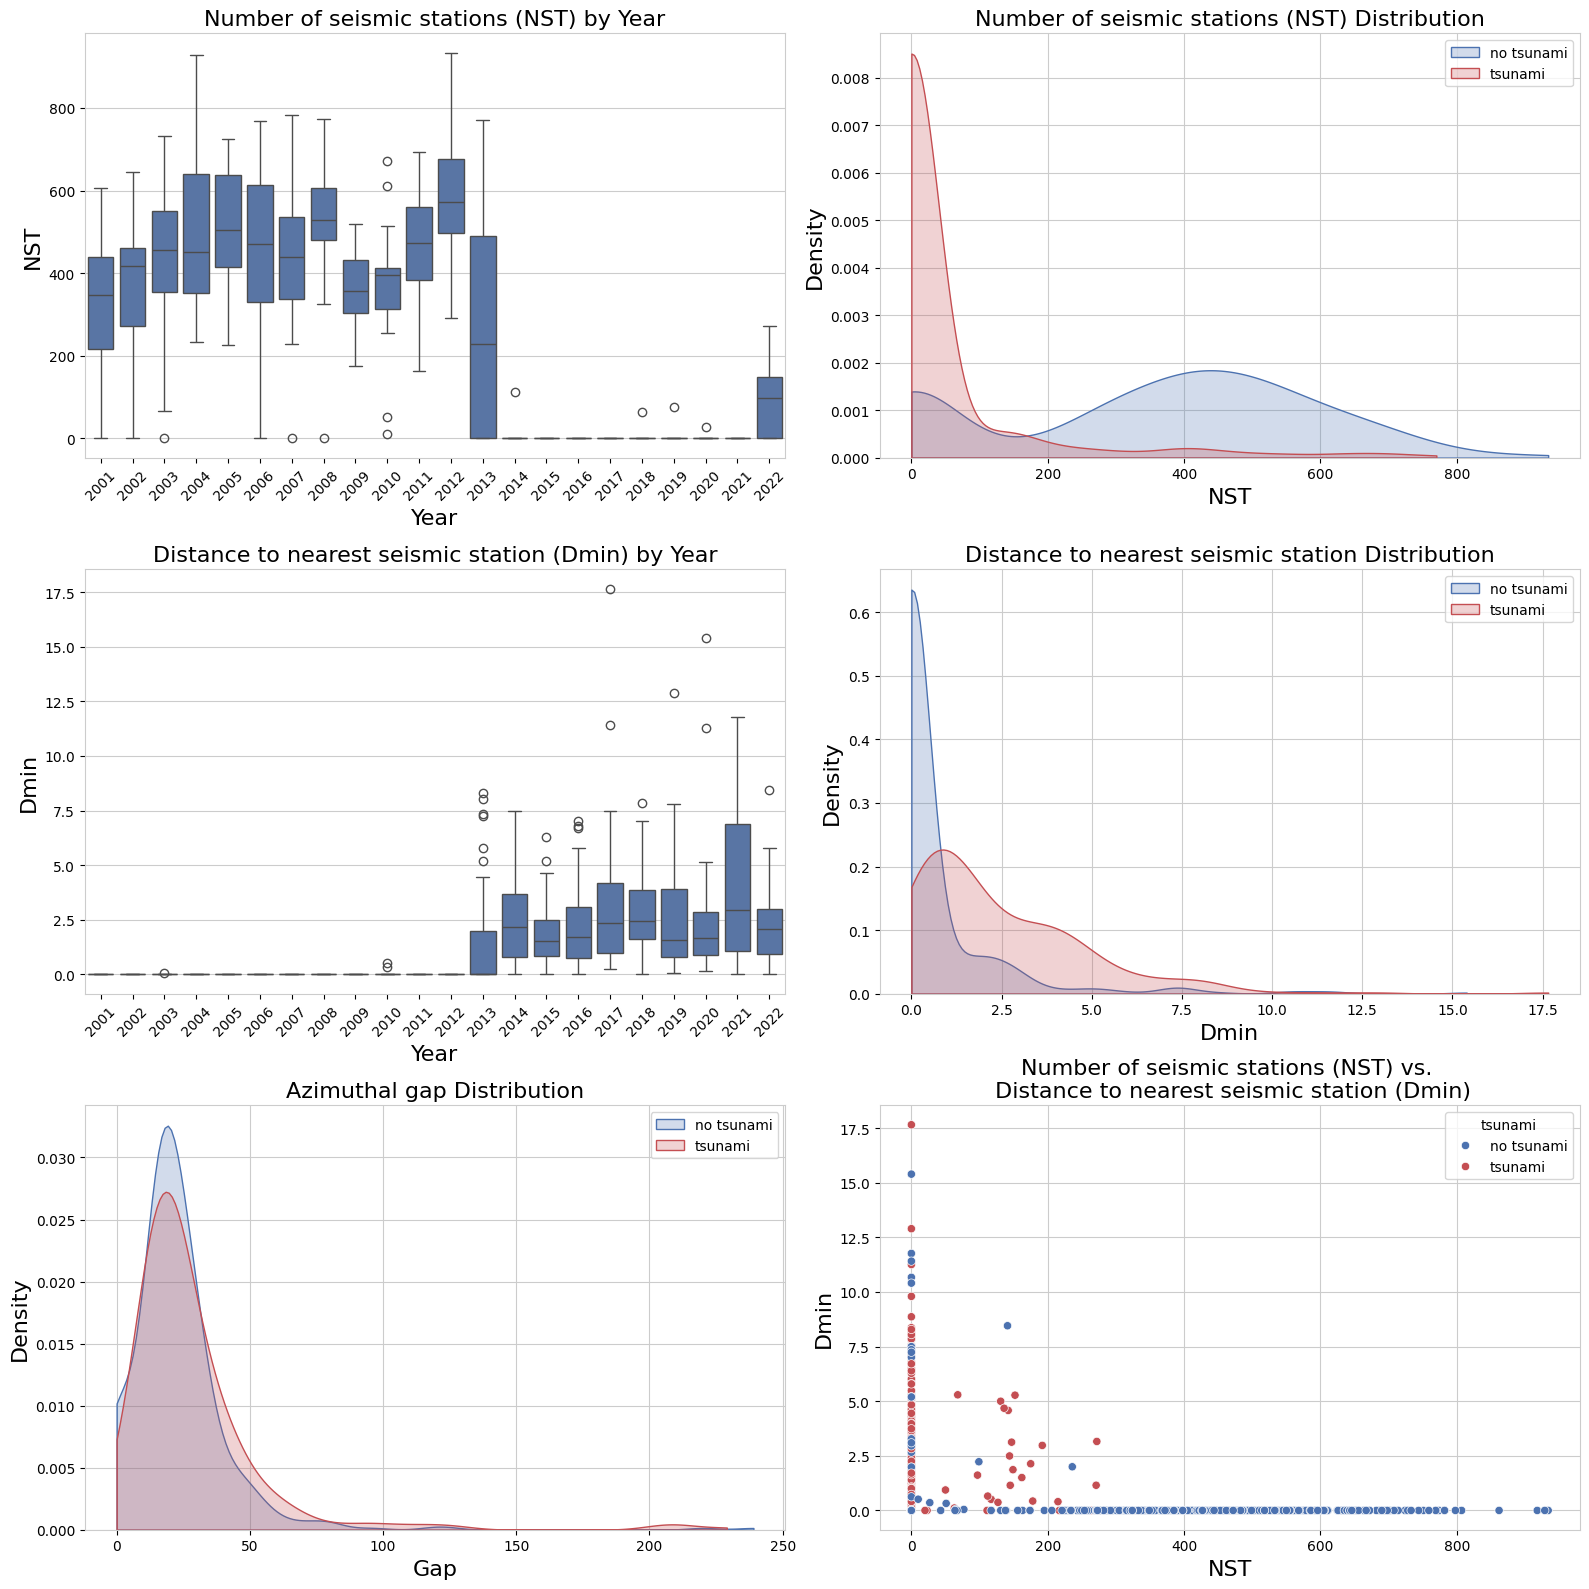

In [9]:
# nst, dmin, gap
fig, axs = plt.subplots(3, 2, figsize=(16, 16))

ax = axs[0, 0]
sns.boxplot(data=df, ax=ax, x="Year", y='nst')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('NST', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Number of seismic stations (NST) by Year', fontsize=16)

ax = axs[0, 1]
sns.kdeplot(data=df[df['tsunami'] == "no tsunami"], ax=ax, x="nst", fill=True, cut=0)
sns.kdeplot(data=df[df['tsunami'] == "tsunami"], ax=ax, x="nst", fill=True, cut=0)
ax.set_xlabel('NST', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.legend(['no tsunami', 'tsunami'])
ax.set_title('Number of seismic stations (NST) Distribution', fontsize=16)

ax = axs[1, 0]
sns.boxplot(data=df, ax=ax, x="Year", y='dmin')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Dmin', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Distance to nearest seismic station (Dmin) by Year', fontsize=16)

ax = axs[1, 1]
sns.kdeplot(data=df[df['tsunami'] == "no tsunami"], ax=ax, x="dmin", fill=True, cut=0)
sns.kdeplot(data=df[df['tsunami'] == "tsunami"], ax=ax, x="dmin", fill=True, cut=0)
ax.set_xlabel('Dmin', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.legend(['no tsunami', 'tsunami'])
ax.set_title('Distance to nearest seismic station Distribution', fontsize=16)

ax = axs[2, 0]
sns.kdeplot(data=df[df['tsunami'] == "no tsunami"], ax=ax, x="gap", fill=True, cut=0)
sns.kdeplot(data=df[df['tsunami'] == "tsunami"], ax=ax, x="gap", fill=True, cut=0)
ax.set_xlabel('Gap', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.legend(['no tsunami', 'tsunami'])
ax.set_title('Azimuthal gap Distribution', fontsize=16)

ax = axs[2, 1]
sns.scatterplot(data=df, ax=ax, x="nst", y="dmin", hue="tsunami", hue_order=["no tsunami", "tsunami"])
ax.set_xlabel('NST', fontsize=16)
ax.set_ylabel('Dmin', fontsize=16)
ax.set_title('Number of seismic stations (NST) vs. \n Distance to nearest seismic station (Dmin)', fontsize=16)

plt.tight_layout()
plt.show()


## Feature Engineering

In [10]:
# Copy a new dataframe for feature engineering
df_new = df.copy()

# Apply log transform for skewed features
df_new['depth_log'] = np.log1p(df_new['depth'])
df_new['nst_log'] = np.log1p(df_new['nst'])
df_new['gap_log'] = np.log1p(df_new['gap'])

# New features
df_new['mag_depth_ratio'] = df_new['magnitude'] / df_new['depth']

# df_new['depth_category'] = df['depth_category'].map({'Shallow (0-70km)': 1,
#                                                     'Intermediate (70-300km)': 2,
#                                                     'Deep (300-700km)': 3})
#df_new['month_sin'] = np.sin(df_new['Month']) # seasonal patterns

# Drop unwanted columns
df_new = df_new.drop(['depth', 'depth_category', 'nst', 'gap', 'tsunami', 'Year', 'Month'], axis=1)

print(df_new.shape)
df_new.describe()

(782, 12)


,magnitude,cdi,mmi,sig,dmin,latitude,longitude,tsunami_01,depth_log,nst_log,gap_log,mag_depth_ratio
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,870.108696,1.325757,3.538100,52.609199,0.388747,3.542618,3.172095,2.897674,0.328012
std,0.445514,3.169939,1.462724,322.465367,2.218805,27.303429,117.898886,0.487778,1.101211,2.999994,1.033893,0.265909
min,6.500000,0.000000,1.000000,650.000000,0.000000,-61.848400,-179.968000,0.000000,1.308333,0.000000,0.000000,0.010438
25%,6.600000,0.000000,5.000000,691.000000,0.000000,-14.595600,-71.668050,0.000000,2.708050,0.000000,2.748868,0.141976
50%,6.800000,5.000000,6.000000,754.000000,0.000000,-2.572500,109.426000,0.000000,3.306645,4.948735,3.044522,0.265385
75%,7.100000,7.000000,7.000000,909.750000,1.863000,24.654500,148.941000,1.000000,3.926875,6.100319,3.433987,0.493929
max,9.100000,9.000000,9.000000,2910.000000,17.654000,71.631200,179.662000,1.000000,6.509976,6.840547,5.480639,2.407407


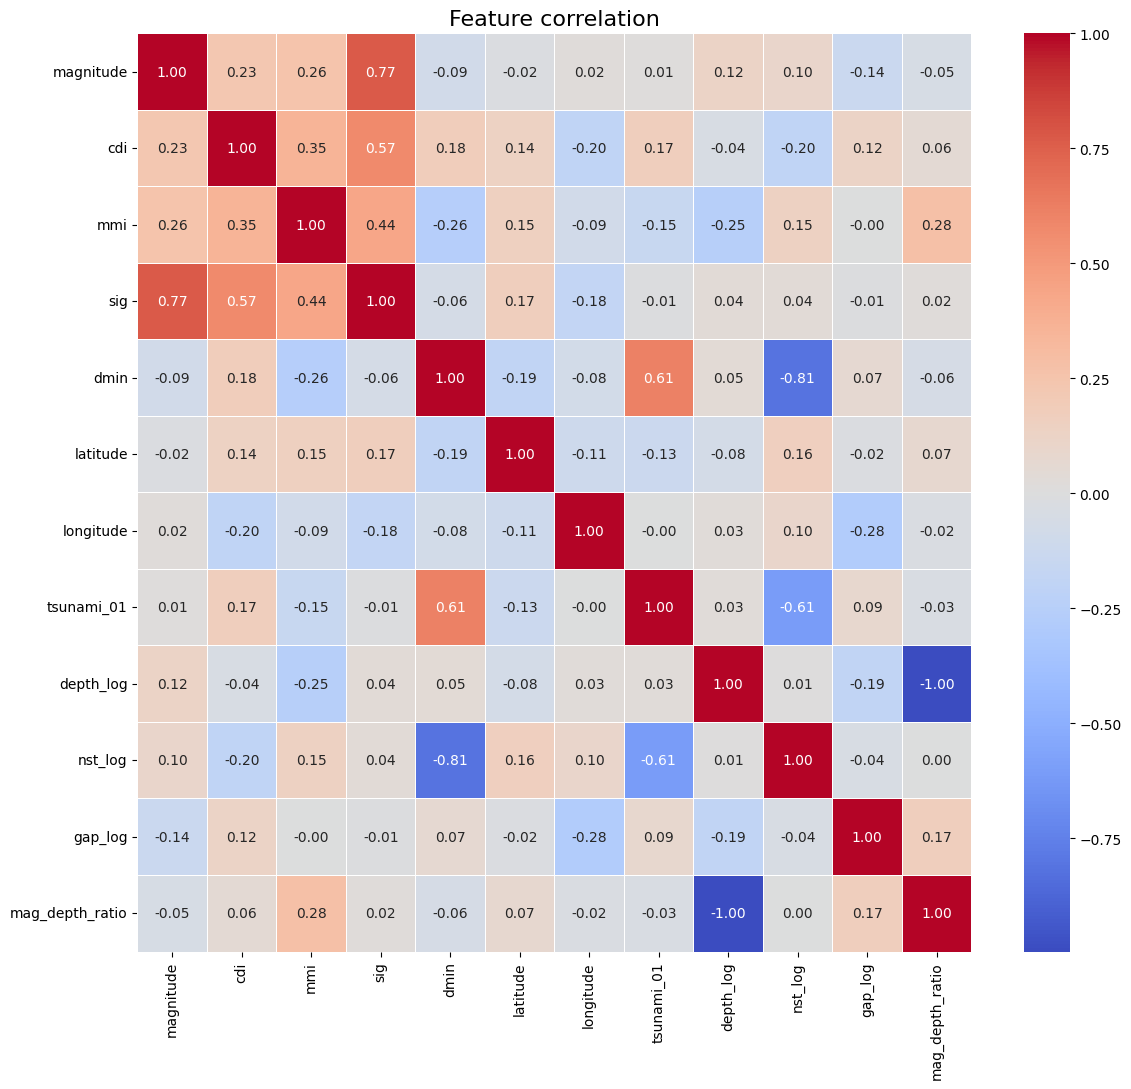

In [11]:
# Feature correlation with engineered features
fig, ax = plt.subplots(figsize=(12, 11))
sns.heatmap(df_new.corr(method='spearman'), ax=ax,
            annot=True, fmt='.2f', linewidth=0.5,
            cmap='coolwarm', center=0)
ax.set_title('Feature correlation', fontsize=16)
plt.tight_layout()
plt.show()

## Data Splitting and preprocessing

In [12]:
# Define X and y columns
X = df_new.drop(['tsunami_01'], axis=1)
y = df_new['tsunami_01']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y,
)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print()
print("Tsunami ratio")
print(f"Train set: {y_train.value_counts(normalize=True)[1]}")
print(f"Test set:  {y_test.value_counts(normalize=True)[1]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Mean of X_train_scaled:  {X_train_scaled.mean():.6f}")
print(f"Standard deviation of X_train_scaled:  {X_train_scaled.std():.6f}")

X_train: (625, 11)
y_train: (625,)
X_test: (157, 11)
y_test: (157,)

Tsunami ratio
Train set: 0.3888
Test set:  0.3885350318471338
Mean of X_train_scaled:  -0.000000
Standard deviation of X_train_scaled:  1.000000


# Model Implementation

## Logistic Regression

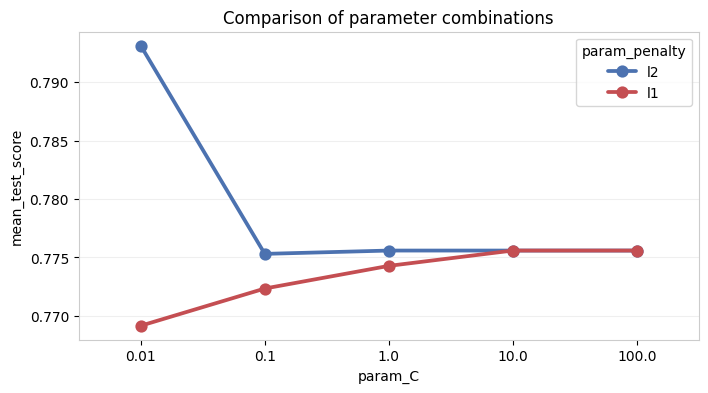

Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Score: 0.7931072786837751


In [13]:
# Search for best parameter combinations
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=LogisticRegression(random_state=random_state, solver='liblinear',
                                 max_iter=1000, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_penalty", "param_C", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,4))
ax = sns.pointplot(results, x="param_C", y="mean_test_score", hue="param_penalty")
ax.set_title("Comparison of parameter combinations")
ax.grid(axis="y", alpha=0.3)
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
lr_model = gs.best_estimator_

## SVM

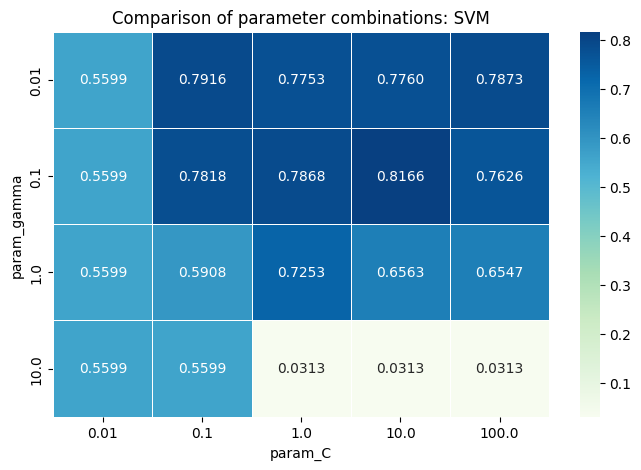

Best Parameters: {'C': 10, 'gamma': 0.1}
Best Score: 0.8165502736924385


In [14]:
# Search for best parameter combinations
param_grid = {
    'gamma': [0.01, 0.1, 1, 10],
    'C': [0.01, 0.1, 1, 10, 100],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=SVC(random_state=random_state, class_weight='balanced', kernel='rbf'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_gamma", "param_C", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(8,5))
results_table = results.pivot_table(index="param_gamma", columns="param_C", values="mean_test_score")
ax = sns.heatmap(results_table, annot=True, fmt='.4f', linewidth=0.5, cmap="GnBu")
ax.set_title("Comparison of parameter combinations: SVM")
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
svm_model = gs.best_estimator_

## Random Forest

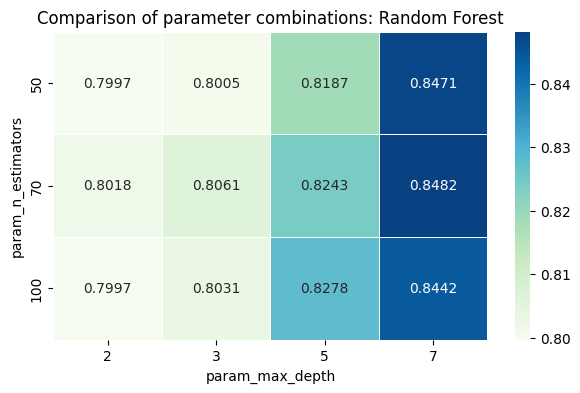

Best Parameters: {'max_depth': 7, 'n_estimators': 70}
Best Score: 0.8482260964753102


In [15]:
# Search for best parameter combinations
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5, 7],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=random_state, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_n_estimators", "param_max_depth", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(7,4))
results_table = results.pivot_table(index="param_n_estimators", columns="param_max_depth", values="mean_test_score")
ax = sns.heatmap(results_table, annot=True, fmt='.4f', linewidth=0.5, cmap="GnBu")
ax.set_title("Comparison of parameter combinations: Random Forest")
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
rf_model = gs.best_estimator_


## Gradient Boosting

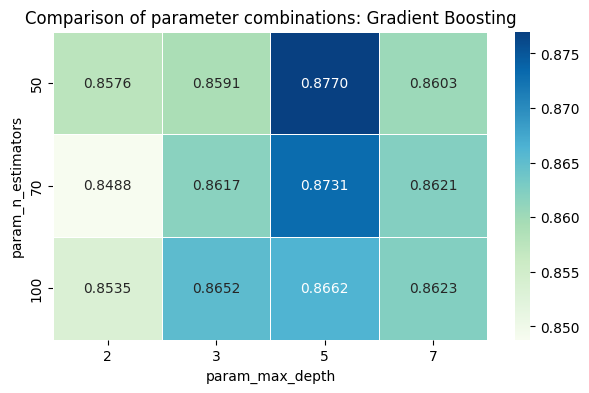

Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Best Score: 0.8770084390955158


In [16]:
# Search for best parameter combinations
param_grid = {
    'n_estimators': [50, 70, 100],
    'max_depth': [2, 3, 5, 7],
}

# Apply GridsearchCV with 5-fold cross validation
cv_split_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
gs = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=random_state),
    param_grid=param_grid,
    cv=cv_split_strategy,
    scoring='f1',
)
gs.fit(X_train_scaled, y_train)

# Show results comparison
results = pd.DataFrame(gs.cv_results_).sort_values(by=["rank_test_score"])
results = results[
    ["param_n_estimators", "param_max_depth", "mean_test_score", "std_test_score", "rank_test_score"]
]

plt.figure(figsize=(7, 4))
results_table = results.pivot_table(index="param_n_estimators", columns="param_max_depth", values="mean_test_score")
ax = sns.heatmap(results_table, annot=True, fmt='.4f', linewidth=0.5, cmap="GnBu")
ax.set_title("Comparison of parameter combinations: Gradient Boosting")
plt.show()

# Save the model with highest score
print("Best Parameters:", gs.best_params_)
print("Best Score:", gs.best_score_)
gb_model = gs.best_estimator_


# Comparison of four models

In [17]:
# Function for obtaining evaluation metrics for specified dataset
def get_eval_metrics(model, X, y_true):
    # Predictions
    y_pred = model.predict(X)
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X)[:, 1] # Probability of Class 1
    else:
        raise AttributeError("Model does not support probability or decision function.")

    # Accuracy metrics
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1 score'] = f1_score(y_true, y_pred)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_scores)

    return metrics

In [18]:
# Define best models
models = {'Logistic Regression': lr_model,
          'SVM': svm_model,
          'Random Forest': rf_model,
          'Gradient Boosting': gb_model}

# Evaluation metrics summary tables
train_metrics = {}
test_metrics = {}

for model_name, model in models.items():
    train_metrics[model_name] = get_eval_metrics(model, X_train_scaled, y_train)
    test_metrics[model_name] = get_eval_metrics(model, X_test_scaled, y_test)

train_metrics_df = pd.DataFrame(train_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("="*80)
print('Summary Tables')
print("="*80)
print(f'Train metrics:\n {train_metrics_df} \n')
print(f'Test metrics:\n {test_metrics_df} \n')

Summary Tables
Train metrics:
            Logistic Regression       SVM  Random Forest  Gradient Boosting
Accuracy              0.816000  0.940800       0.944000                1.0
Precision             0.716216  0.912000       0.906250                1.0
Recall                0.872428  0.938272       0.954733                1.0
F1 score              0.786642  0.924949       0.929860                1.0
ROC-AUC               0.857303  0.985834       0.993892                1.0 

Test metrics:
            Logistic Regression       SVM  Random Forest  Gradient Boosting
Accuracy              0.828025  0.859873       0.898089           0.910828
Precision             0.723684  0.791045       0.846154           0.873016
Recall                0.901639  0.868852       0.901639           0.901639
F1 score              0.802920  0.828125       0.873016           0.887097
ROC-AUC               0.843238  0.912398       0.931182           0.947746 



ROC curves


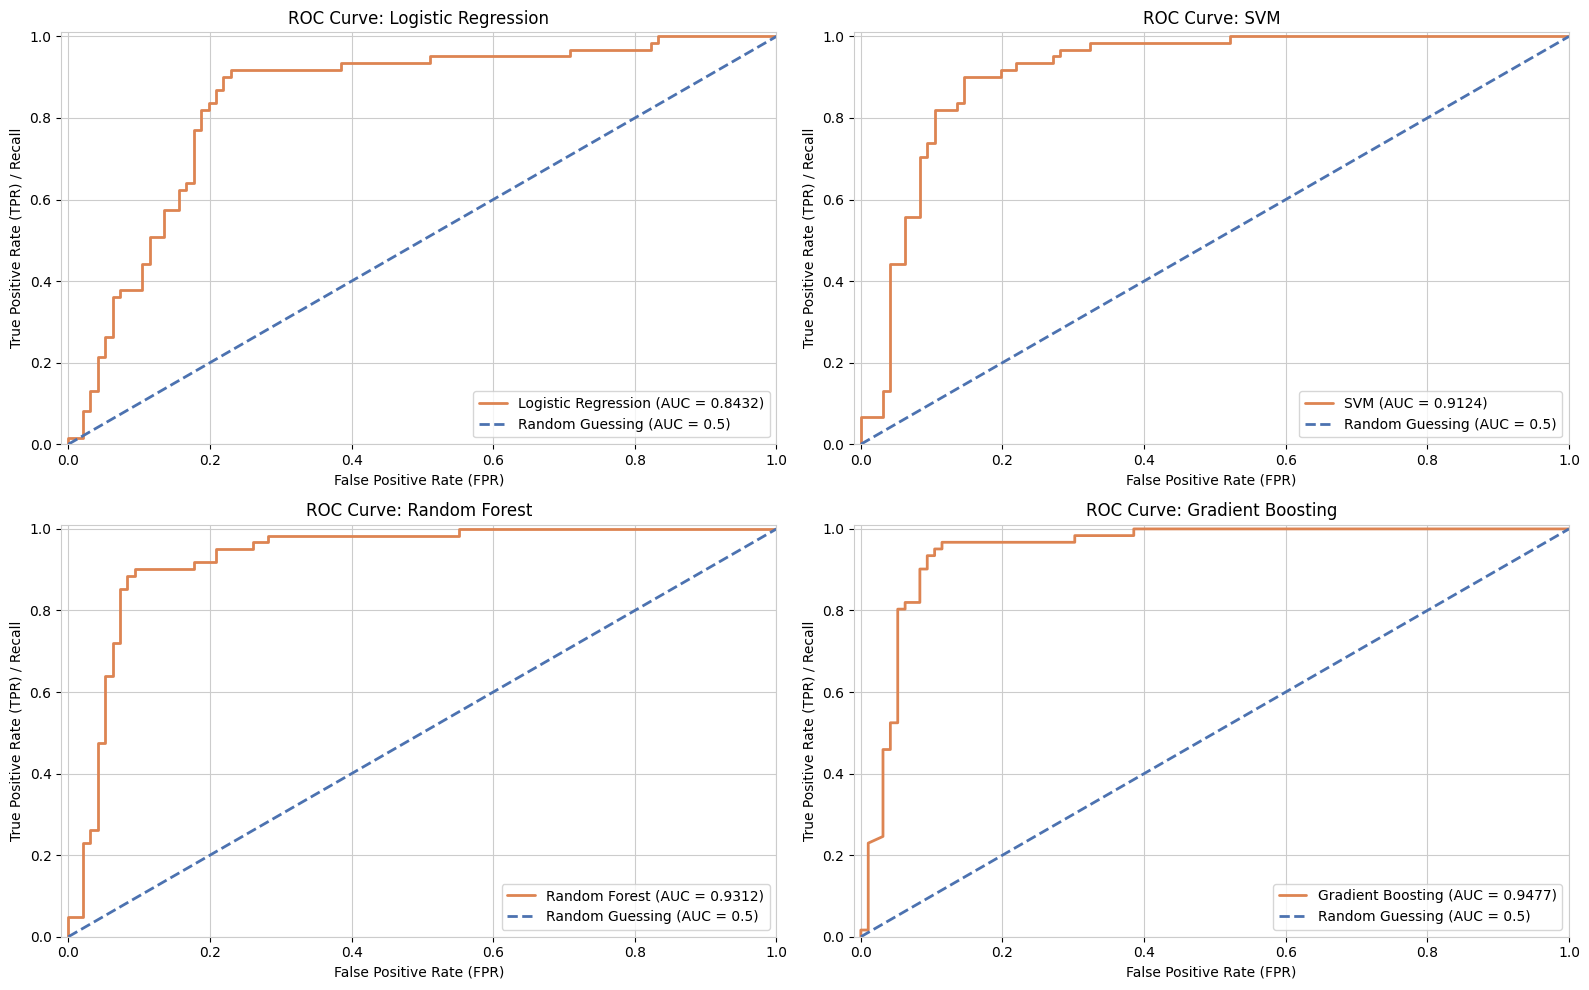

In [19]:
# Function for plotting roc-auc curve
def plot_roc_auc_curve(X_test_scaled, y_test, model, model_name, ax):
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_scaled)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1] # Probability of Class 1
    else:
        raise AttributeError("Model does not support probability or decision function.")

    auc_score = roc_auc_score(y_test, y_scores)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    sns.lineplot(ax=ax, x=fpr, y=tpr, estimator=None, linewidth=2, color='C2', label=f'{model_name} (AUC = {auc_score:.4f})')
    sns.lineplot(ax=ax, x=[0, 1], y=[0, 1], linestyle='--', linewidth=2, color='C0', label='Random Guessing (AUC = 0.5)')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR) / Recall')
    ax.set_title(f'ROC Curve: {model_name}')
    ax.set_xlim(-0.01, 1)
    ax.set_ylim(0, 1.01)
    #ax.grid(True)
    #ax.savefig(f"ROC_AUC_{model_name}", dpi=300, bbox_inches="tight")

# Plot ROC-AUC curves
print("="*80)
print('ROC curves')
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    plot_roc_auc_curve(X_test_scaled, y_test, model, model_name, ax)

plt.tight_layout()
plt.show()

Confusion matrices


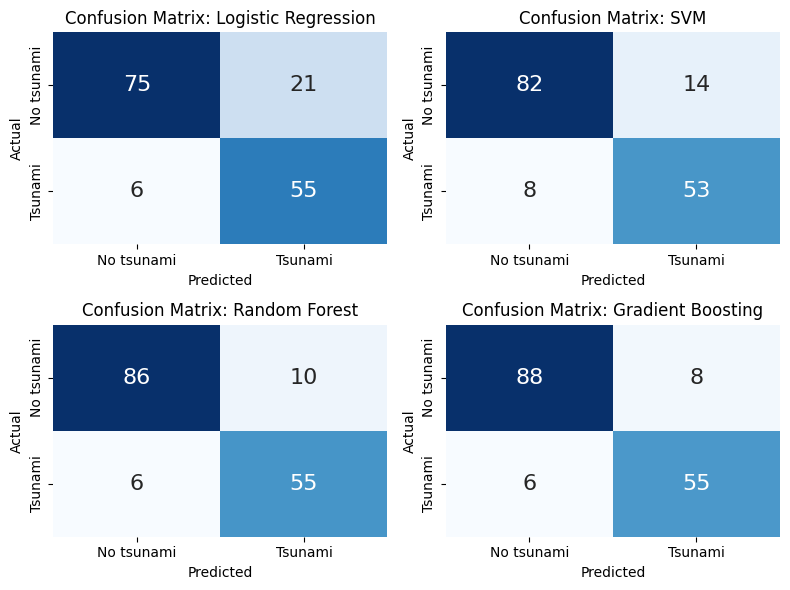

In [20]:
# Plot confusion matrices
print("="*80)
print('Confusion matrices')
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for idx, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    confusion = confusion_matrix(y_test, y_pred)

    ax = axes[idx]
    sns.heatmap(confusion, ax=ax, annot=True, annot_kws={"fontsize": 16}, fmt="d", cmap="Blues", cbar=False)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xticklabels(['No tsunami', 'Tsunami'])
    ax.set_yticklabels(['No tsunami', 'Tsunami'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Feature Importance

**Impurity based feature importance:**
combines the fraction of samples a feature contributes to the final prediction with its
corresponding decrease in impurity
- bias towards high cardinality features
- calculated only on training data, misleading if model is overfitting

**Permutation importance**:
easures the decrease in a model’s evaluation score when a specific
feature’s values are randomly shuffled during training/testing stage.
- no bias
- can be applied on training/testing set and all model types

In [21]:
# Feature importance
def plot_feature_importance(data, ax, model_name):
    sns.barplot(data=data, orient='y', ax=ax)
    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=12)
    ax.set_title(f'Feature Importance: {model_name}', fontsize=16, pad=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    ax.set_ylabel('')

# Permutation importance
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X, y, ax, data_name, model_name):
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=random_state, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()[::-1]
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=features[sorted_importances_idx],
    )

    sns.boxplot(data=importances, ax=ax, orient='y', fill=False, color='C0',
                medianprops={"color": "C2", "linewidth": 2})
    ax.set_title(f"Permutation Importances ({data_name} set): {model_name}", fontsize=16)
    ax.set_xlabel("Decrease in accuracy score", fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    ax.axvline(x=0, color="k", linestyle="--")

# Calculate feature importances
features = X.columns
lr_importance = pd.Series(lr_model.coef_[0], index=features).sort_values(ascending=False)
rf_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
gb_importance = pd.Series(gb_model.feature_importances_, index=features).sort_values(ascending=False)

/tmp/ipython-input-4013311890.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


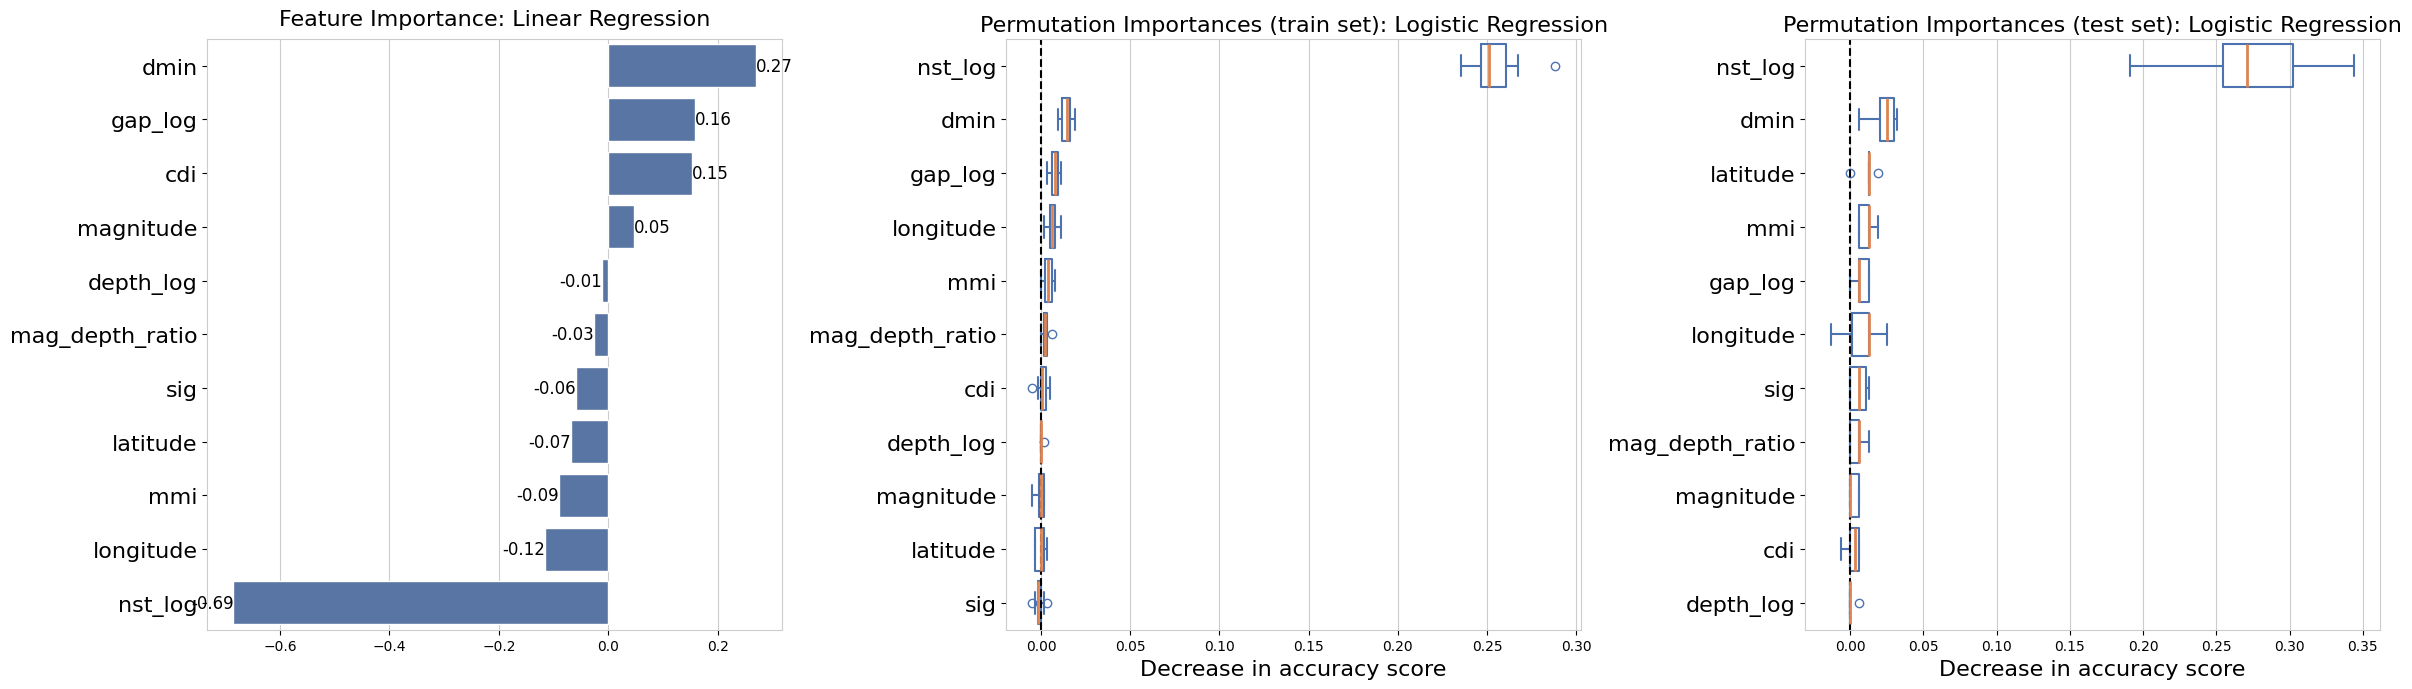

In [22]:
# Logistic Regression
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
ax = axs[0]
plot_feature_importance(lr_importance, ax, 'Linear Regression')

ax = axs[1]
plot_permutation_importance(lr_model, X_train_scaled, y_train, ax, 'train', 'Logistic Regression')

ax = axs[2]
plot_permutation_importance(lr_model, X_test_scaled, y_test, ax, 'test', 'Logistic Regression')

plt.tight_layout()
plt.show()

/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


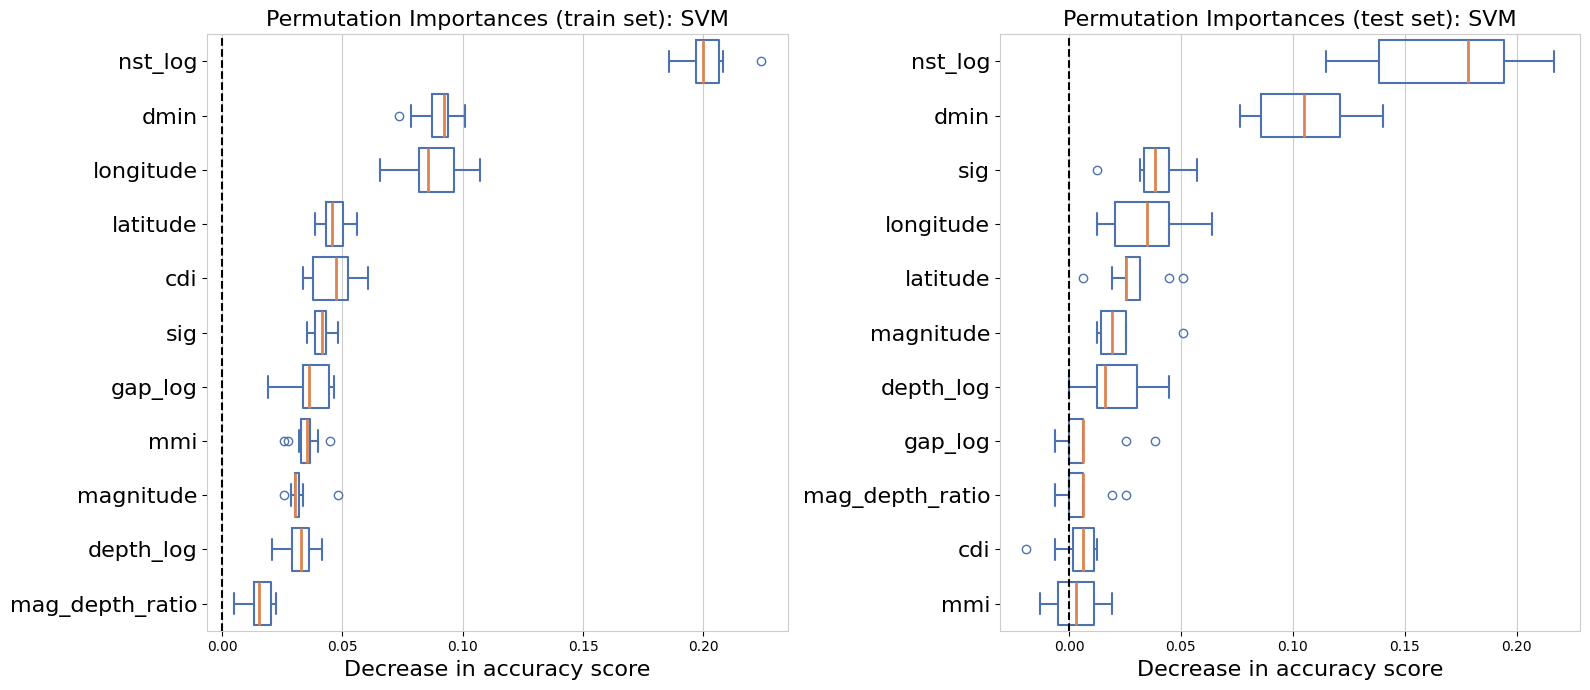

In [23]:
# SVM
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

ax = axs[0]
plot_permutation_importance(svm_model, X_train_scaled, y_train, ax, 'train', 'SVM')

ax = axs[1]
plot_permutation_importance(svm_model, X_test_scaled, y_test, ax, 'test', 'SVM')

plt.tight_layout()
plt.show()

/tmp/ipython-input-4013311890.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


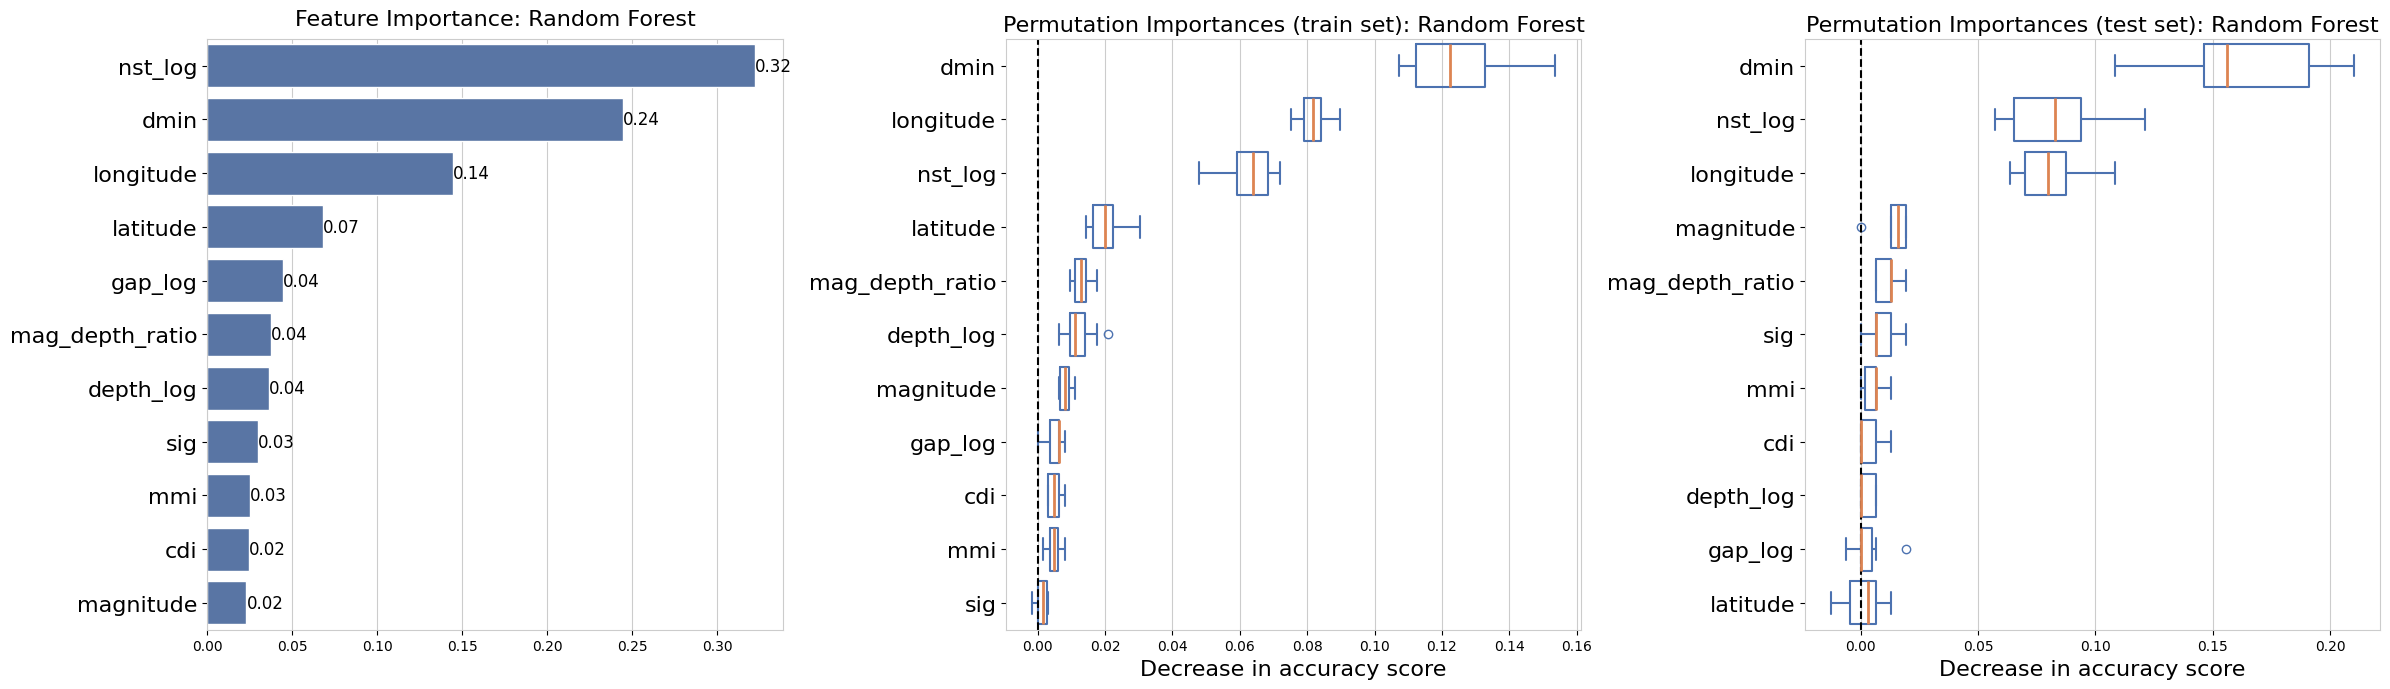

In [24]:
# Random forest: Impurity & Permutation based feature importance

fig, axs = plt.subplots(1, 3, figsize=(24, 7))
ax = axs[0]
plot_feature_importance(rf_importance, ax, 'Random Forest')
ax = axs[1]
plot_permutation_importance(rf_model, X_train_scaled, y_train, ax, 'train', 'Random Forest')
ax = axs[2]
plot_permutation_importance(rf_model, X_test_scaled, y_test, ax, 'test', 'Random Forest')

plt.tight_layout()
plt.show()

/tmp/ipython-input-4013311890.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


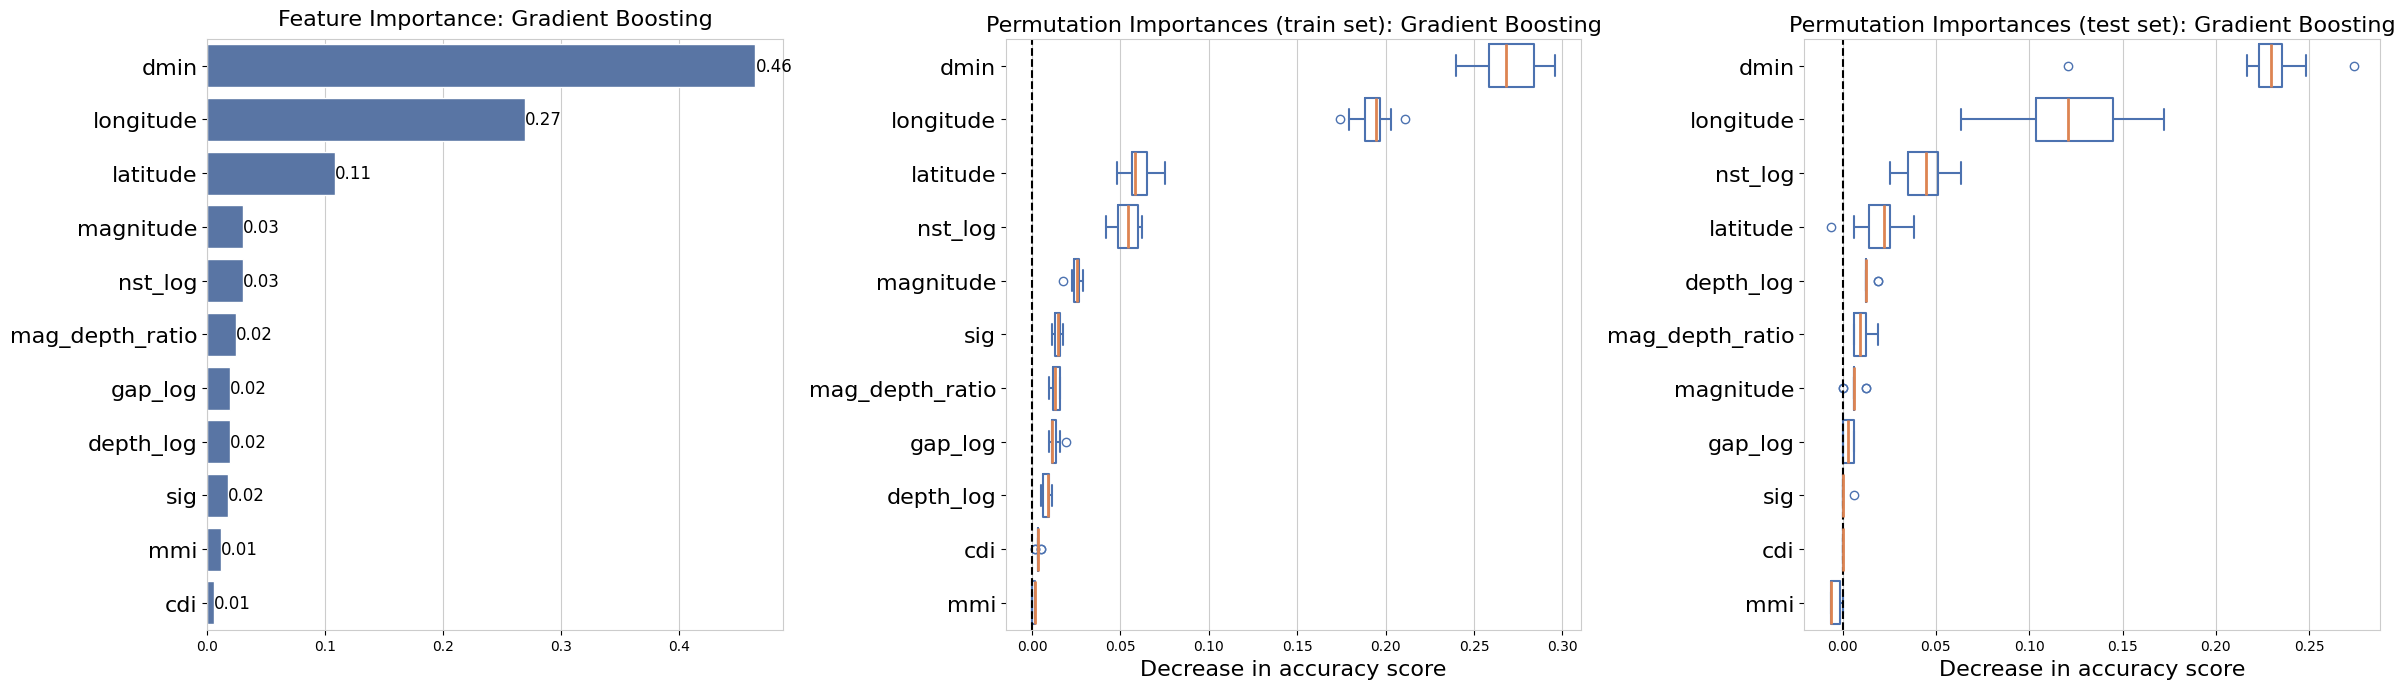

In [25]:
# Gradient Boosting: Impurity & Permutation based feature importance
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
ax = axs[0]
plot_feature_importance(gb_importance, ax, 'Gradient Boosting')
ax = axs[1]
plot_permutation_importance(gb_model, X_train_scaled, y_train, ax, 'train', 'Gradient Boosting')
ax = axs[2]
plot_permutation_importance(gb_model, X_test_scaled, y_test, ax, 'test', 'Gradient Boosting')

plt.tight_layout()
plt.show()

/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
/tmp/ipython-input-4013311890.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


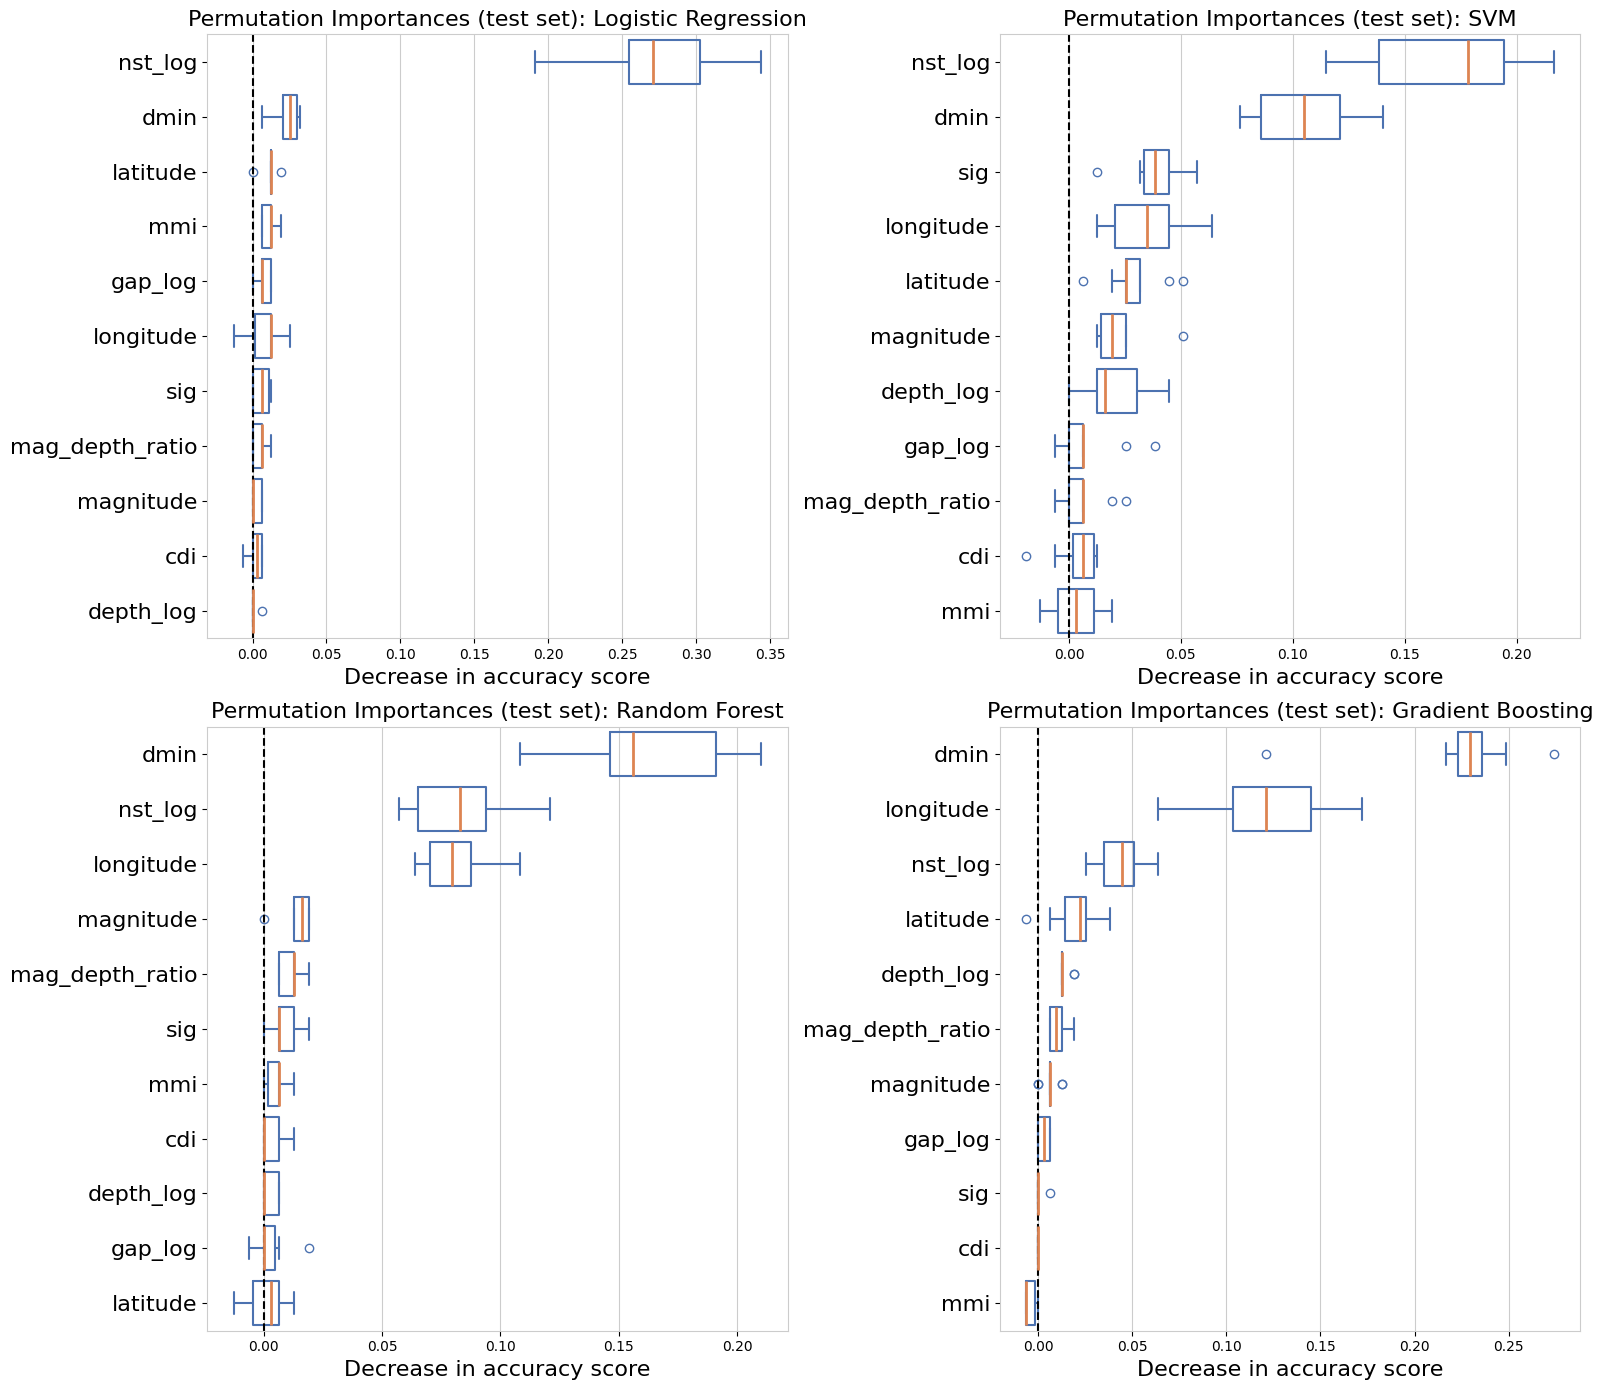

In [26]:
# Permutation importance on test set
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
ax = axs[0, 0]
plot_permutation_importance(lr_model, X_test_scaled, y_test, ax, 'test', 'Logistic Regression')
ax = axs[0, 1]
plot_permutation_importance(svm_model, X_test_scaled, y_test, ax, 'test', 'SVM')
ax = axs[1, 0]
plot_permutation_importance(rf_model, X_test_scaled, y_test, ax, 'test', 'Random Forest')
ax = axs[1, 1]
plot_permutation_importance(gb_model, X_test_scaled, y_test, ax, 'test', 'Gradient Boosting')

plt.tight_layout()
plt.show()

## Checklist
- ✓ Feature importance graph
- ✓ Write comparisons of model performance before and after data pruning
- ✓ Feature engineering: coastal, near pacific ring of fire, subduction zones, Moment Magnitude
- Adjust decision threshold values
- Select some features and train to see if there is a difference
- Implement more models
- Write report updated

## References

https://scikit-learn.org/stable/modules/classification_threshold.html

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

https://www.usgs.gov/programs/earthquake-hazards/determining-depth-earthquake

https://oceancolor.gsfc.nasa.gov/resources/docs/distfromcoast/
